In [1]:
# !pip install pycaret
# !pip install scikit-learn-intelex

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
data = pd.read_csv('data/train.csv')
data.columns = ['time', 'temperature', 'humidity']

In [4]:
# preprocess wrong time data
# -------------

start_time = datetime(2024, 7, 13, 21, 3, 55)
end_time = datetime(2024, 7, 13, 21, 30, 24)
timestamps = pd.date_range(start=start_time, end=end_time, freq='3S')

# ensure data['time'] column is in datetime format
data['time'] = pd.to_datetime(data['time'])

data.loc[:524, 'time'] = timestamps[:525]

# save time column to data_time
data_time = data['time']
data.drop(columns='time', inplace=True)

data.head()

,temperature,humidity
0,26.2,73.0
1,26.2,73.0
2,26.2,73.0
3,26.2,72.0
4,26.2,72.0


In [5]:
# pyCaret's API
# -------------

from pycaret.anomaly import *
s = setup(data, session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(664, 2)"
2,Transformed data shape,"(664, 2)"
3,Numeric features,2
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


In [6]:
# to load model
# -------------

# iforest = load_model('model/iforest_pipeline')
# print(iforest)

In [7]:
# create the isolation forest model
# -------------

iforest = create_model('iforest')
print(iforest)

IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=123, verbose=0)


In [8]:
result = assign_model(iforest)
result

,temperature,humidity,Anomaly,Anomaly_Score
0,26.200001,73.0,0,-0.335420
1,26.200001,73.0,0,-0.335420
2,26.200001,73.0,0,-0.335420
3,26.200001,72.0,0,-0.324156
4,26.200001,72.0,0,-0.324156
...,...,...,...,...
659,26.200001,72.0,0,-0.324156
660,26.200001,72.0,0,-0.324156
661,26.200001,72.0,0,-0.324156
662,26.200001,72.0,0,-0.324156


In [9]:
result_time = result.copy()
result_time['time'] = data_time

In [10]:
result_time.head()

,temperature,humidity,Anomaly,Anomaly_Score,time
0,26.200001,73.0,0,-0.335420,2024-07-13 21:03:55
1,26.200001,73.0,0,-0.335420,2024-07-13 21:03:58
2,26.200001,73.0,0,-0.335420,2024-07-13 21:04:01
3,26.200001,72.0,0,-0.324156,2024-07-13 21:04:04
4,26.200001,72.0,0,-0.324156,2024-07-13 21:04:07


In [11]:
result_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   temperature    664 non-null    float32       
 1   humidity       664 non-null    float32       
 2   Anomaly        664 non-null    int32         
 3   Anomaly_Score  664 non-null    float64       
 4   time           664 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float32(2), float64(1), int32(1)
memory usage: 18.3 KB


In [12]:
anomaly_count = (result['Anomaly'] == 1).sum()

print(f"Anomaly count: {anomaly_count}")

Anomaly count: 32


In [13]:
# plot function
# -------------

def plot_line(df):
    df['time'] = pd.to_datetime(df['time'])
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # temperature plot
    ax1.plot(df['time'], df['temperature'], label='Temperature', color='red')
    ax1.set_ylabel('Temperature (°C)', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.set_title('Temperature Over Time')
    ax1.set_xticklabels([])

    # humidity plot
    ax2.plot(df['time'], df['humidity'], label='Humidity', color='blue')
    ax2.set_ylabel('Humidity (%)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_title('Humidity Over Time')
    ax2.set_xticklabels([])

    # filter anomalies
    anomalies = df[df['Anomaly'] == 1]

    # dots for anomalies
    ax1.scatter(anomalies['time'], anomalies['temperature'], color='green', label='Anomaly', s=50, zorder=5)
    ax2.scatter(anomalies['time'], anomalies['humidity'], color='green', s=50, zorder=5)

    ax1.legend()
    ax2.legend()

    plt.xlabel('Time')
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

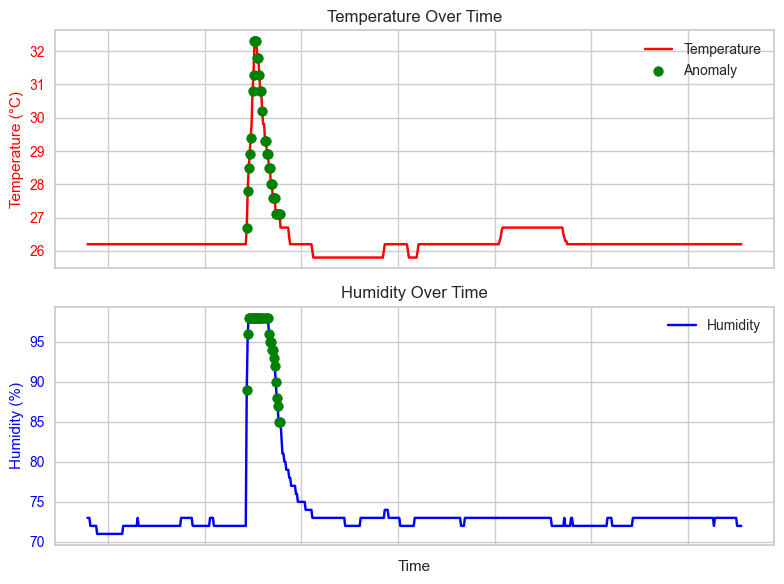

In [14]:
plot_line(result_time)

In [15]:
# test new data
# -------------

test_data = pd.read_csv('data/test.csv')
test_data.columns = ['time', 'temperature', 'humidity']

In [16]:
test_time = test_data['time']
test_data.drop(columns='time', inplace=True)

In [17]:
prediction = predict_model(iforest, data = test_data)
prediction.head()

,temperature,humidity,Anomaly,Anomaly_Score
0,26.2,73.0,0,-0.33542
1,26.2,73.0,0,-0.33542
2,26.2,73.0,0,-0.33542
3,26.2,73.0,0,-0.33542
4,26.2,73.0,0,-0.33542


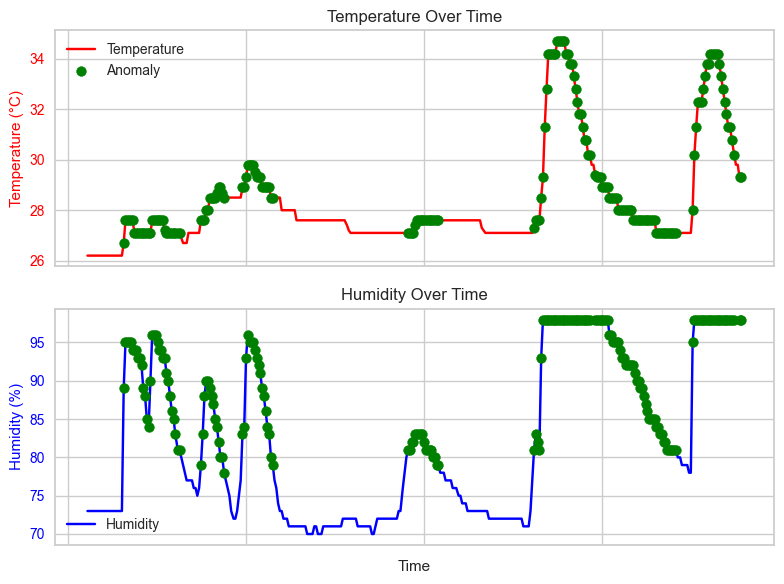

In [18]:
test_with_time = prediction.copy()
test_with_time['time'] = test_time

plot_line(test_with_time)

In [19]:
# to save model
# -------------

save_model(iforest, 'model/iforest_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['temperature', 'humidity'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model',
                  IForest(behaviour='new', bootstrap=False, contamination=0.05,
     max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
     random_state=123, verbose=0))]),
 'model/iforest_pipeline.pkl')